# Introduction

La classification automatique (clustering) est un outil statistique permettant de regrouper des objets similaires en classes.

Elle est utilisée dans plusieurs domaines sous des noms différents :

Dans la gestion de relation client, on parle de segmentation, utilisée souvent pour identifier les segments de clientèle, c’est-à-dire l’ensemble des clients ayant le même profil en fonction de certaines caractéristiques : l’âge, le sexe, la catégorie socio-professionnelle, etc… 

Connue en biologie sous le nom de taxinomie, elle sert à regrouper les organismes vivants en groupes appelés taxons.

En informatique, elle permet de réaliser des tâches de reconnaissance de forme, etc…
La classification automatique suppose que les données observées ne sont pas labellisées, c’est-à-dire qu’aucune connaissance sur les classes des objets n’est disponible à priori.

Il existe plusieurs approches pour réaliser des tâches de clustering :

* Méthode de partitionnement : consiste à partitionner les données de façon itérative
* Méthode hiérarchique : créer des groupes par agrégations successives
* Méthode probabiliste : trouver le modèle statistique des données


**Importation des données**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (7, 5)
plt.style.use('ggplot')
data = pd.read_table("data/fromage.txt", sep="\t", header=0, index_col=0)
print(data.shape)

(29, 9)


In [2]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
calories,29.0,300.034483,91.914356,70.0,292.0,321.0,355.0,406.0
sodium,29.0,210.086207,108.678923,22.0,140.0,223.0,276.0,432.0
calcium,29.0,185.734483,72.528882,72.6,132.9,202.3,220.5,334.6
lipides,29.0,24.158621,8.129642,3.4,23.4,26.3,29.1,33.3
retinol,29.0,67.562069,24.163098,37.1,51.6,62.3,76.4,150.5
folates,29.0,13.010345,11.723339,1.2,4.9,6.4,21.1,36.4
proteines,29.0,20.168966,6.959788,4.1,17.8,21.0,23.4,35.7
cholesterol,29.0,74.586207,28.245755,10.0,70.0,80.0,90.0,120.0
magnesium,29.0,26.965517,11.318388,10.0,20.0,26.0,30.0,51.0


## Les méthodes de réallocation

Le principe de cette méthode consiste à :

* **Fixer à priori le nombre de classes n**   
Le nombre de de la classe est fixé au départ.

* **Initialiser des classes**   
Cela se fait souvent de façon aléatoire.

* **Réallocation des individus**   
A chaque itération, chaque individu est affecté à la classe dont le centre est le plus proche.    
Les centres de classes sont mis jour avec les individus rattachés

* **Répéter la réallocation des individus jusqu'à la convergence**

In [3]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(data)

KMeans(n_clusters=4)

In [4]:
idk = np.argsort(kmeans.labels_)
data_cluster = pd.DataFrame({'CLUSTER_ID': kmeans.labels_[idk]})
data_cluster.index = data.index[idk]
data_cluster.head(5)

,CLUSTER_ID
Fromages,
CarredelEst,0
Tome,0
PontlEveque,0
Chabichou,0
Chaource,0


**Métrique silhouette pour choisir le bon nombre de classe**

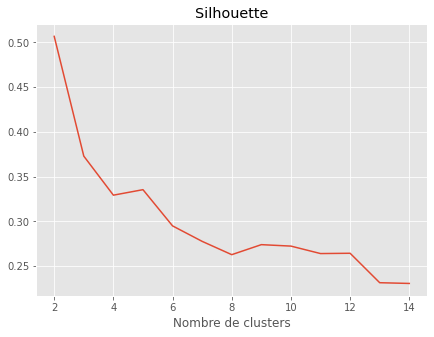

In [5]:
from sklearn import metrics
res = []
for k in range(2, 15):
    km = cluster.KMeans(n_clusters=k)
    km.fit(data)
    res.append(metrics.silhouette_score(data, km.labels_))

plt.title("Silhouette")
plt.xlabel("Nombre de clusters")
plt.plot(range(2, 15),res)
plt.show()

**Analyse des classes**

In [6]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from scipy import stats

def summary_class_info(df, class_id=1):
    data_0 = df[df.CLUSTER_ID == class_id]
    data_0 = pd.DataFrame(data_0.drop(['CLUSTER_ID'], axis=1).describe().transpose())[[ 'mean', 'std']]
    data_0.columns = pd.MultiIndex.from_tuples([('CLUSTER', 'MEAN'), ('CLUSTER', 'STD')])
    data_1 = pd.DataFrame(df.drop(['CLUSTER_ID'], axis=1).describe().transpose())[[ 'mean', 'std']]
    data_1.columns = pd.MultiIndex.from_tuples([('GENERAL', 'MEAN'), ('GENERAL', 'STD')])
    columns = df.columns.tolist()
    columns.remove('CLUSTER_ID')
    data_2 = pd.DataFrame(columns=['STATISTIQUE', 'P_VALUE'], index= columns)
    for col in columns:
        vect_0 = df[df.CLUSTER_ID == class_id][col].values
        vect_1 = df[col].values
        test = stats.ttest_ind(vect_0, vect_1)
        data_2.loc[col] = [test.statistic, test.pvalue]
    data_2.columns = pd.MultiIndex.from_tuples([('TEST', 'STATISTIQUE'), ('TEST', 'P_VALUE')])
    res = data_0.join(data_1)
    res = res.join(data_2)
    return res
def importance_variable_in_cluster(data, class_id=1):
    data['TARGET'] = data['CLUSTER_ID'].map(lambda x : 1 if x == class_id else 0)
    data = data.drop('CLUSTER_ID', axis=1)
    train = data.drop('TARGET', axis=1)
    y_train = data['TARGET']
    clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    clf.fit(X=train, y=y_train)
    plt.rcParams['figure.figsize'] = (8, 5)
    plot_importance(clf, show_values=False)
    plt.show()

In [7]:
all_data = data.join(data_cluster)
all_data.head(5)

,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium,CLUSTER_ID
Fromages,,,,,,,,,,
CarredelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20,0
Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27,3
Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41,2
Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27,3
Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20,3


**Classe 0**

Classe 0 , Effectif = 7


CLUSTER                GENERAL                    TEST  \
                   MEAN        STD        MEAN         STD STATISTIQUE   
calories     297.857143  43.788996  300.034483   91.914356   -0.060532   
sodium       239.785714  62.767997  210.086207  108.678923    0.690827   
calcium      103.842857  33.988373  185.734483   72.528882   -2.887356   
lipides       24.914286   3.179847   24.158621    8.129642    0.239337   
retinol       83.928571  37.432148   67.562069   24.163098    1.440327   
folates       23.057143  13.110156   13.010345   11.723339    1.991485   
proteines     18.971429   3.710218   20.168966    6.959788   -0.437133   
cholesterol   71.428571  10.690450   74.586207   28.245755   -0.288138   
magnesium     21.714286   7.409775   26.965517   11.318388   -1.161861   

                       
              P_VALUE  
calories     0.952086  
sodium       0.494364  
calcium      0.006709  
lipides      0.812281  
retinol      0.158921  
folates      0.054510  
proteines    0.664779  
cholesterol  0.774990  
magnesium    0.253383


Classe 0 : Importance des variables


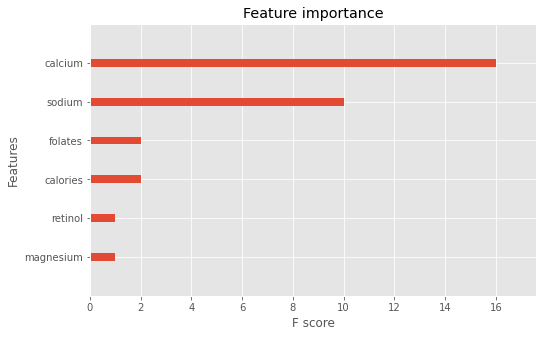


Classe 0 : Profil des individus


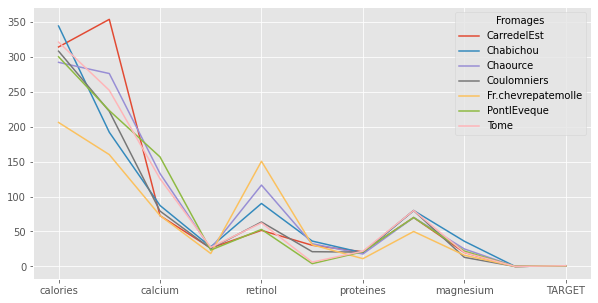

Classe 1 , Effectif = 4


CLUSTER                GENERAL                    TEST          
                MEAN        STD        MEAN         STD STATISTIQUE   P_VALUE
calories     101.750  33.049206  300.034483   91.914356   -4.226607  0.000194
sodium        44.750  31.941353  210.086207  108.678923   -2.987418  0.005460
calcium      133.750  61.849845  185.734483   72.528882   -1.361898  0.183046
lipides        6.275   3.430622   24.158621    8.129642   -4.298865  0.000158
retinol       55.150  10.462154   67.562069   24.163098   -1.003337  0.323466
folates       16.475   9.121906   13.010345   11.723339    0.564982  0.576152
proteines      7.200   2.287648   20.168966    6.959788   -3.654971  0.000943
cholesterol   18.250   8.883505   74.586207   28.245755   -3.913984  0.000464
magnesium     11.250   1.892969   26.965517   11.318388   -2.735068  0.010221
TARGET         0.000   0.000000    0.241379    0.435494   -1.093431  0.282629


Classe 1 : Importance des variables


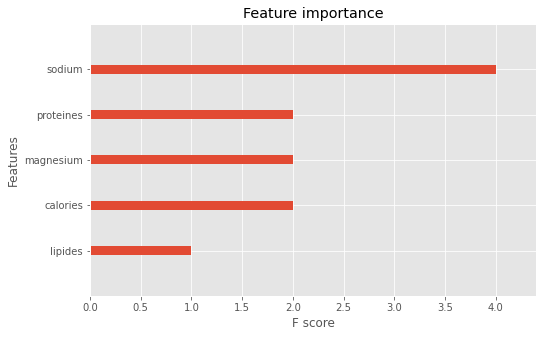


Classe 1 : Profil des individus


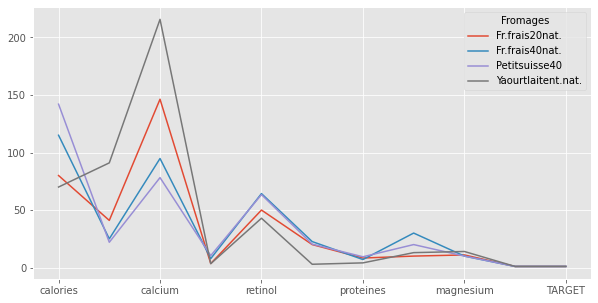

Classe 2 , Effectif = 8


CLUSTER                GENERAL                    TEST          
                 MEAN        STD        MEAN         STD STATISTIQUE   P_VALUE
calories     363.8750  42.116971  300.034483   91.914356    1.895405  0.066321
sodium       146.1250  59.161854  210.086207  108.678923   -1.589828  0.120867
calcium      257.0250  49.755596  185.734483   72.528882    2.602948  0.013465
lipides       29.0500   3.698648   24.158621    8.129642    1.642489  0.109445
retinol       63.6000  13.475268   67.562069   24.163098   -0.442189  0.661073
folates        3.8625   2.050044   13.010345   11.723339   -2.176266  0.036371
proteines     26.5625   5.254369   20.168966    6.959788    2.406117  0.021540
cholesterol   96.2500  20.658793   74.586207   28.245755    2.016619  0.051459
magnesium     38.8750   9.478359   26.965517   11.318388    2.717240  0.010165
TARGET         0.0000   0.000000    0.137931    0.350931   -1.100368  0.278682


Classe 2 : Importance des variables


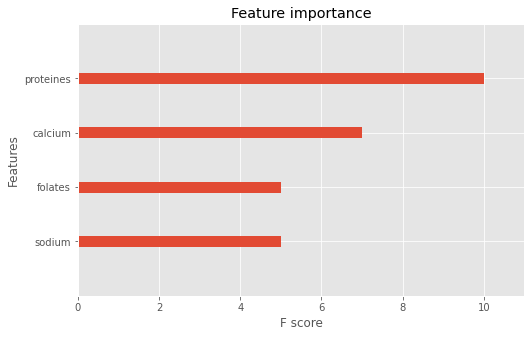


Classe 2 : Profil des individus


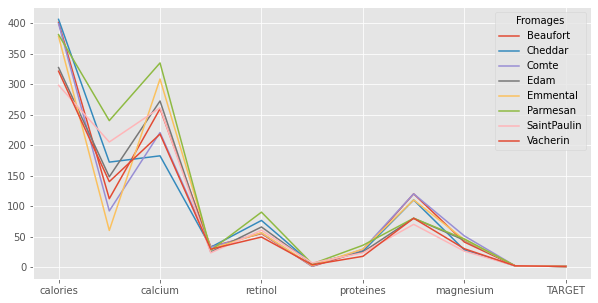

Classe 3 , Effectif = 10


CLUSTER                GENERAL                    TEST          
               MEAN        STD        MEAN         STD STATISTIQUE   P_VALUE
calories     329.80  34.298688  300.034483   91.914356    0.993141  0.327092
sodium       306.60  65.076365  210.086207  108.678923    2.636007  0.012187
calcium      206.82  31.086932  185.734483   72.528882    0.885531  0.381590
lipides       26.87   3.505567   24.158621    8.129642    1.015552  0.316438
retinol       64.24  20.039638   67.562069   24.163098   -0.390006  0.698768
folates       11.91  11.064302   13.010345   11.723339   -0.259414  0.796754
proteines     21.08   2.275375   20.168966    6.959788    0.403452  0.688938
cholesterol   82.00  12.292726   74.586207   28.245755    0.798809  0.429499
magnesium     27.40   5.777350   26.965517   11.318388    0.115588  0.908604
TARGET         0.00   0.000000    0.275862    0.454859   -1.901095  0.065100


Classe 3 : Importance des variables


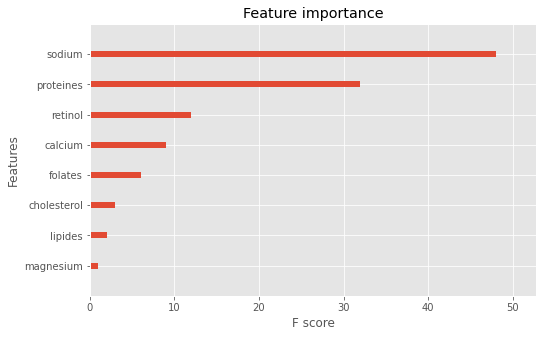


Classe 3 : Profil des individus


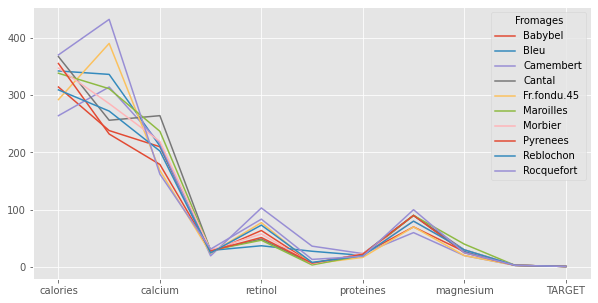

In [8]:
for i in range(4):
    n = all_data[all_data.CLUSTER_ID == i].shape[0]
    print('Classe %i , Effectif = %i' % (i, n))
    res = summary_class_info(df=all_data, class_id=i)
    display(res)
    print()
    print('Classe %i : Importance des variables' % i)
    importance_variable_in_cluster(data=all_data, class_id=i)
    print()
    print('Classe %i : Profil des individus' % i)
    _ = all_data[all_data['CLUSTER_ID'] == i].transpose().plot(figsize=(10, 5))
    plt.show()

## Classification ascendante hiérarchique (CAH)
Cet algorithme fonctionne de la manière suivante :
* Calculer le tableau des distances entre individus    
Le choix de la mesure de similarité entre individus (distance euclidienne, distance cosinus, ...)
* Former les groupes
    * Définir la mesure d'agrégation de deux groupes : saut minimum (single linkage), saut maximum (complete linkage), distance de Ward
    * A départ chaque individu constitue un groupe
* A chaque étape, on agrège les deux groupes les plus proches
* L'algorithme s'arrête lorsque tous les individus forment un seul groupe

Le nombre de classe est un paramètre à fixer.

In [9]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import numpy as np
    
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendrogramme CAH (trunqué)')
        plt.xlabel('Index ou taille des classes')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

data_linkage = linkage(data, method='ward', metric='euclidean')
c, coph_dists = cophenet(data_linkage, pdist(data))                    

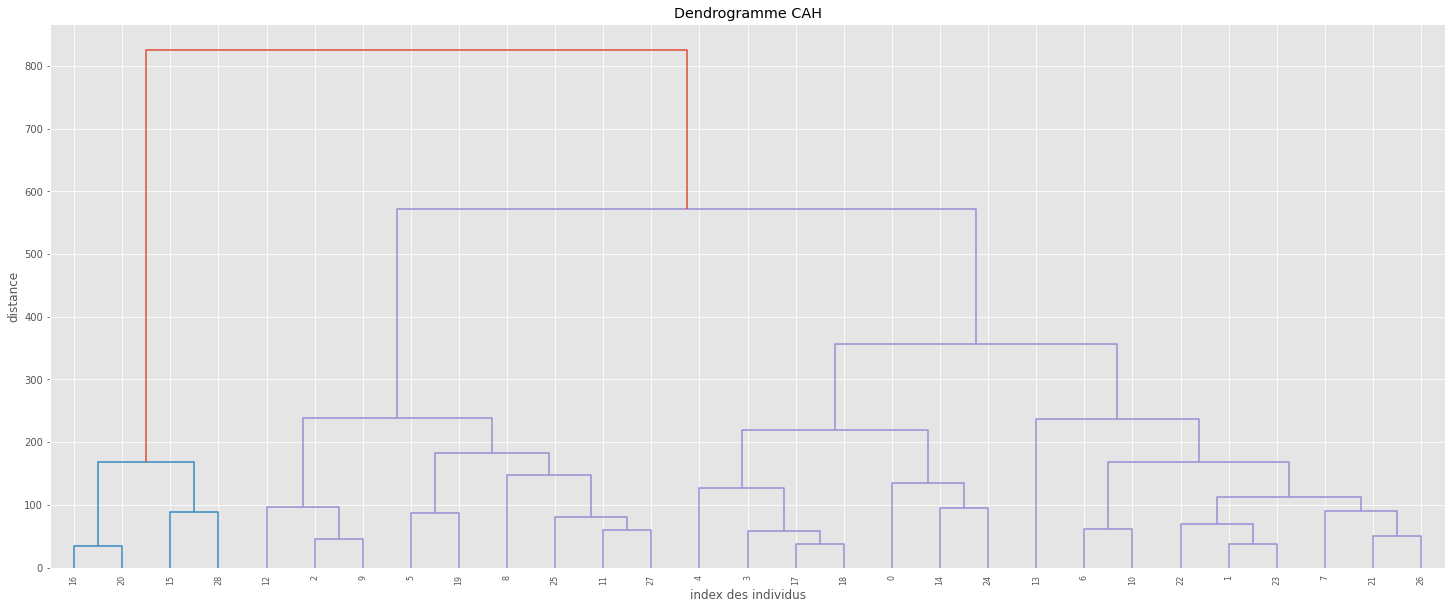

In [10]:
plt.figure(figsize=(25, 10))
plt.title('Dendrogramme CAH')
plt.xlabel('index des individus')
plt.ylabel('distance')
dendrogram(
    data_linkage,
    leaf_rotation=90., 
    leaf_font_size=8.,
)
plt.show()

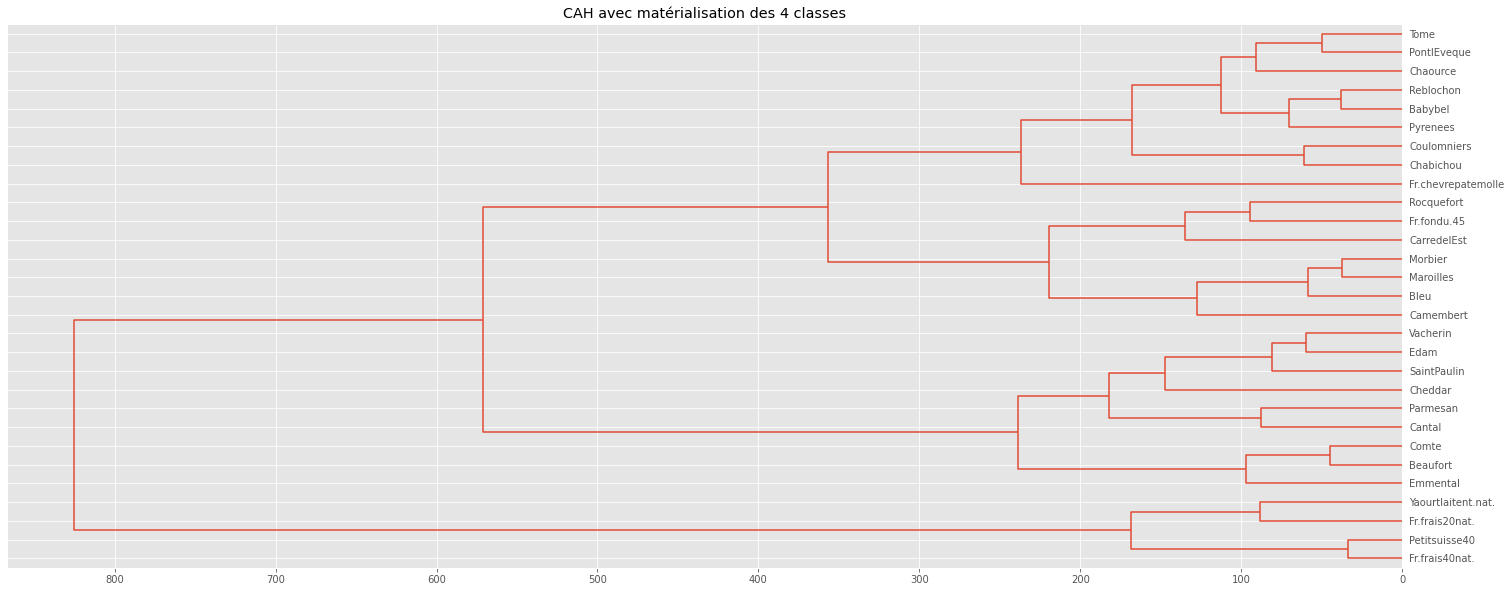

In [11]:
plt.figure(figsize=(25, 10))
plt.title('CAH avec matérialisation des 4 classes')
dendrogram(data_linkage, labels=data.index, orientation='left', color_threshold=7)
plt.show()

Nombre de clusters :  4


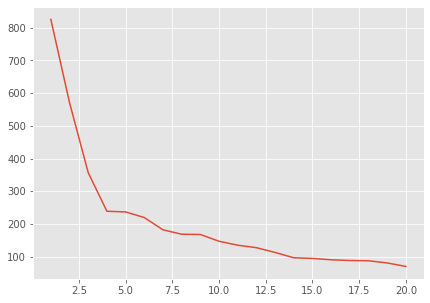

In [12]:
plt.figure(figsize=(7, 5))
last = data_linkage[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2) 
acceleration_rev = acceleration[::-1]
k = acceleration_rev.argmax() + 2 
print("Nombre de clusters : ", k)

In [13]:
k = 4
groupes_cah = fcluster(data_linkage, k, criterion='maxclust')
idg = np.argsort(groupes_cah)
data_cluster = pd.DataFrame({'CLUSTER_ID':groupes_cah[idg]})
data_cluster.index = data.index[idg]
data_cluster.head(5)

,CLUSTER_ID
Fromages,
Yaourtlaitent.nat.,1
Petitsuisse40,1
Fr.frais40nat.,1
Fr.frais20nat.,1
SaintPaulin,2


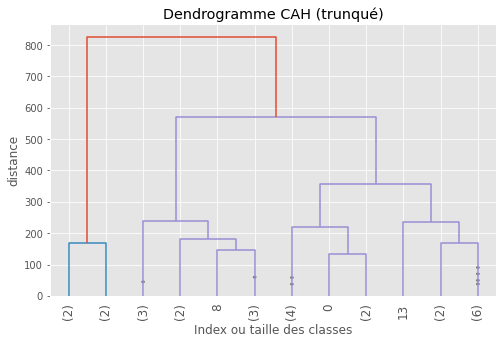

In [14]:
plt.title('Dendrogramme CAH (trunqué)')
plt.xlabel('Index ou taille des classes')
plt.ylabel('distance')
dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()

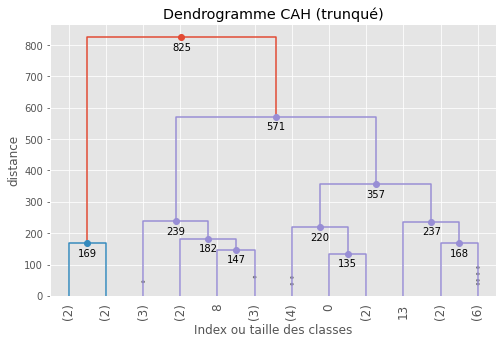

In [15]:
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10
)
plt.show()

In [16]:
all_data = data.join(data_cluster)
all_data.head(5)

,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium,CLUSTER_ID
Fromages,,,,,,,,,,
CarredelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20,3
Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27,4
Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41,2
Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27,3
Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20,3


Classe 1 , Effectif = 4


CLUSTER                GENERAL                    TEST          
                MEAN        STD        MEAN         STD STATISTIQUE   P_VALUE
calories     101.750  33.049206  300.034483   91.914356   -4.226607  0.000194
sodium        44.750  31.941353  210.086207  108.678923   -2.987418  0.005460
calcium      133.750  61.849845  185.734483   72.528882   -1.361898  0.183046
lipides        6.275   3.430622   24.158621    8.129642   -4.298865  0.000158
retinol       55.150  10.462154   67.562069   24.163098   -1.003337  0.323466
folates       16.475   9.121906   13.010345   11.723339    0.564982  0.576152
proteines      7.200   2.287648   20.168966    6.959788   -3.654971  0.000943
cholesterol   18.250   8.883505   74.586207   28.245755   -3.913984  0.000464
magnesium     11.250   1.892969   26.965517   11.318388   -2.735068  0.010221


Classe 1 : Importance des variables


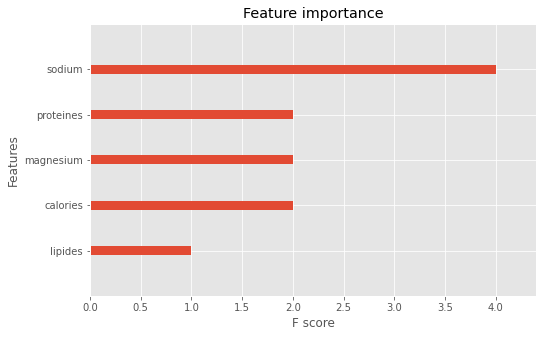


Classe 1 : Profil des individus


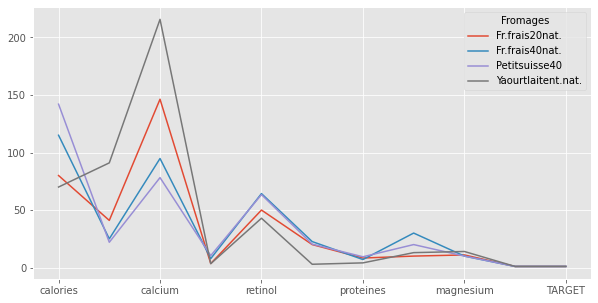

Classe 2 , Effectif = 9


CLUSTER                GENERAL                    TEST  \
                   MEAN        STD        MEAN         STD STATISTIQUE   
calories     364.222222  39.410588  300.034483   91.914356    2.022798   
sodium       158.333333  66.362640  210.086207  108.678923   -1.345264   
calcium      257.800000  46.600134  185.734483   72.528882    2.792587   
lipides       29.022222   3.460772   24.158621    8.129642    1.733506   
retinol       61.955556  13.535981   67.562069   24.163098   -0.660534   
folates        4.066667   2.013082   13.010345   11.723339   -2.257583   
proteines     26.166667   5.056432   20.168966    6.959788    2.387195   
cholesterol   95.555556  19.436506   74.586207   28.245755    2.070519   
magnesium     37.888889   9.346717   26.965517   11.318388    2.623721   
TARGET         0.000000   0.000000    0.137931    0.350931   -1.167994   

                       
              P_VALUE  
calories     0.050570  
sodium       0.186953  
calcium      0.008320  
lipides      0.091564  
retinol      0.513116  
folates      0.030133  
proteines    0.022352  
cholesterol  0.045634  
magnesium    0.012677  
TARGET       0.250486


Classe 2 : Importance des variables


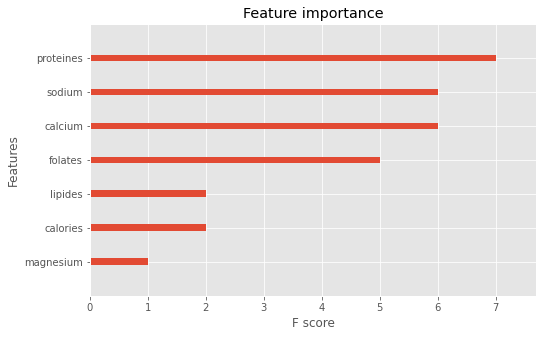


Classe 2 : Profil des individus


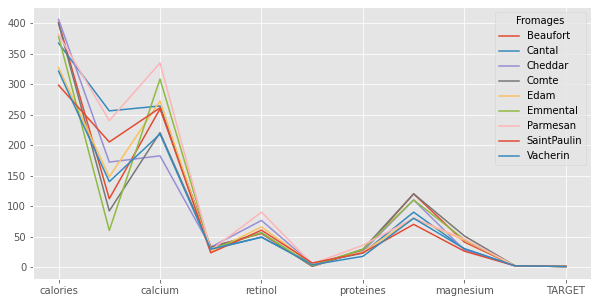

Classe 3 , Effectif = 7


CLUSTER                GENERAL                    TEST  \
                   MEAN        STD        MEAN         STD STATISTIQUE   
calories     323.857143  36.260302  300.034483   91.914356    0.667176   
sodium       345.928571  50.757946  210.086207  108.678923    3.196886   
calcium      183.685714  56.106786  185.734483   72.528882   -0.069589   
lipides       26.928571   4.033491   24.158621    8.129642    0.868951   
retinol       65.271429  23.406247   67.562069   24.163098   -0.226348   
folates       17.485714  13.618545   13.010345   11.723339    0.879792   
proteines     20.585714   2.423791   20.168966    6.959788    0.154691   
cholesterol   80.000000  14.142136   74.586207   28.245755    0.488589   
magnesium     26.000000   7.325754   26.965517   11.318388   -0.213828   
TARGET         0.000000   0.000000    0.310345    0.470824   -1.724819   

                       
              P_VALUE  
calories     0.509163  
sodium       0.002999  
calcium      0.944929  
lipides      0.390967  
retinol      0.822286  
folates      0.385148  
proteines    0.877980  
cholesterol  0.628269  
magnesium    0.831958  
TARGET       0.093641


Classe 3 : Importance des variables


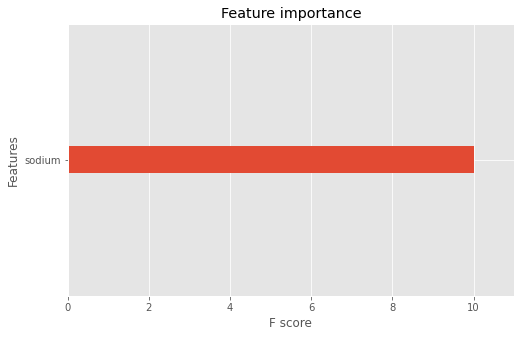


Classe 3 : Profil des individus


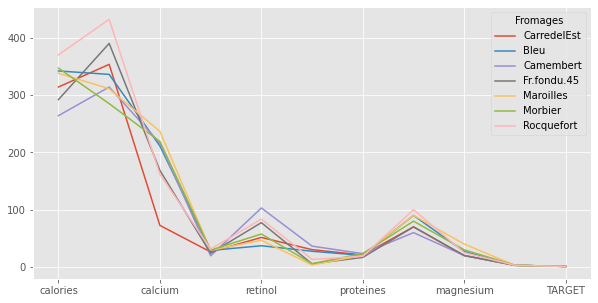

Classe 4 , Effectif = 9


CLUSTER                GENERAL                    TEST  \
                   MEAN        STD        MEAN         STD STATISTIQUE   
calories     305.444444  42.391364  300.034483   91.914356    0.169824   
sodium       229.666667  36.891733  210.086207  108.678923    0.526798   
calcium      138.366667  52.180456  185.734483   72.528882   -1.811439   
lipides       25.088889   2.918238   24.158621    8.129642    0.333954   
retinol       80.466667  33.226608   67.562069   24.163098    1.278781   
folates       16.933333  13.260656   13.010345   11.723339    0.850963   
proteines     19.611111   3.539931   20.168966    6.959788   -0.229848   
cholesterol   74.444444  11.303883   74.586207   28.245755   -0.014585   
magnesium     23.777778   7.031674   26.965517   11.318388   -0.794298   
TARGET         0.000000   0.000000    0.241379    0.435494   -1.647094   

                       
              P_VALUE  
calories     0.866099  
sodium       0.601565  
calcium      0.078423  
lipides      0.740352  
retinol      0.209156  
folates      0.400415  
proteines    0.819511  
cholesterol  0.988444  
magnesium    0.432227  
TARGET       0.108242


Classe 4 : Importance des variables


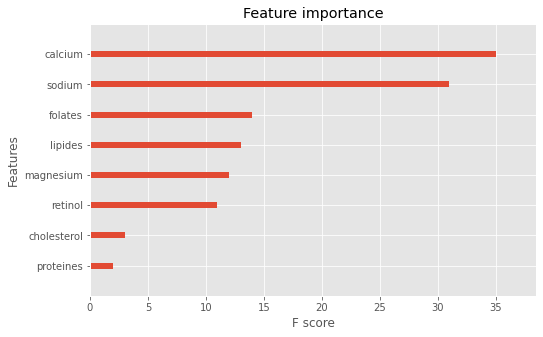


Classe 4 : Profil des individus


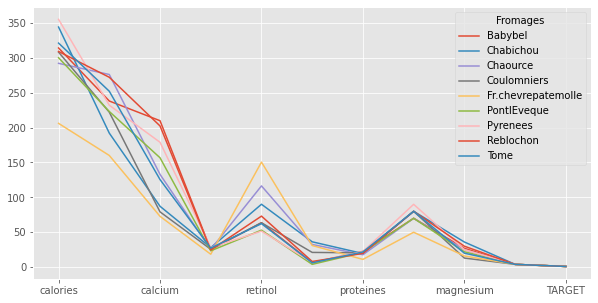

In [17]:
for i in range(1, 5):
    n = all_data[all_data.CLUSTER_ID == i].shape[0]
    print('Classe %i , Effectif = %i' % (i, n))
    res = summary_class_info(df=all_data, class_id=i)
    display(res)
    print()
    print('Classe %i : Importance des variables' % i)
    importance_variable_in_cluster(data=all_data, class_id=i)
    print()
    print('Classe %i : Profil des individus' % i)
    _ = all_data[all_data['CLUSTER_ID'] == i].transpose().plot(figsize=(10, 5))
    plt.show()

Il existe d'autres types d'algorithmes de clustering implémentés par [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering):
* DBSCAN
* Spectral clustering
* Agglomerative clustering
* Gaussian mixtures
* ...

**Références** :   
[Cours de Ricco Rakotomalala](http://eric.univ-lyon2.fr/~ricco/cours)       
[Cours de Marie Chavent](http://www.math.u-bordeaux.fr/~mchave100p/teaching/)  